# Data On Scale: Decoding Obesity Risk with Explainable AI

<b>Background:</b>

Obesity is a multifactorial condition influenced by genetic predisposition, dietary habits, physical activity levels, and environmental factors. While traditional epidemiological studies have identified these contributors, their interactions remain complex and difficult to quantify using conventional analytical techniques. Machine learning (ML) has emerged as a powerful tool in healthcare research, offering the ability to analyze vast datasets, recognize hidden patterns, and generate predictive insights. Among ML models, Extreme Gradient Boosting (XGBoost) has shown particular effectiveness in handling complex, non-linear relationships, making it well-suited for obesity classification.

In addition to predictive modeling, the interpretability of ML models is critical for translating algorithmic outputs into actionable recommendations. Explainable AI techniques such as SHapley Additive exPlanations (SHAP) and Diverse Counterfactual Explanations (DICE) enable researchers to not only identify key obesity risk factors but also provide personalized intervention strategies. This study integrates these methodologies to classify obesity risk across four categories—underweight, normal weight, overweight, and obese—while offering individualized recommendations for lifestyle modifications. By leveraging ML interpretability, this research aims to bridge the gap between obesity prediction and practical intervention, offering insights that can inform public health policies, healthcare providers, and individuals in managing and preventing obesity more effectively.

# 1. Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

palette = sns.set_palette("deep")

import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.set_option("display.max_rows",100)

TARGET = "obesity_type"
n_splits = 3
RANDOM_SEED = 42

data_df = pd.read_csv("../data/raw/obesity_data.csv")
data_df.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:

print(f"Total number of rows: {len(data_df)}")
print(f"Total number of columns: {data_df.shape[1]}\n")
display(data_df.describe())
display(data_df.info())

Total number of rows: 20758
Total number of columns: 18



,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.00000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,10378.50000,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5992.46278,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,0.00000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,5189.25000,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,10378.50000,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,15567.75000,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,20757.00000,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

None

In [5]:
# Check counts, column dtypes, null and unique count in each Column
tmp = pd.DataFrame(index=data_df.columns)
tmp['count'] = data_df.count()
tmp['dtype'] = data_df.dtypes
tmp['nunique'] = data_df.nunique()
tmp['%nunique'] = (tmp['nunique']/len(data_df))*100
tmp['%null'] = (data_df.isnull().sum()/len(data_df))*100

tmp = tmp.round(3)

display(tmp)
del tmp

,count,dtype,nunique,%nunique,%null
id,20758,int64,20758,100.000,0.0
Gender,20758,object,2,0.010,0.0
Age,20758,float64,1703,8.204,0.0
Height,20758,float64,1833,8.830,0.0
Weight,20758,float64,1979,9.534,0.0
family_history_with_overweight,20758,object,2,0.010,0.0
FAVC,20758,object,2,0.010,0.0
FCVC,20758,float64,934,4.499,0.0
NCP,20758,float64,689,3.319,0.0
CAEC,20758,object,4,0.019,0.0


# 2. Data Exploration and Preprocessing

In [6]:
#Renaming features to more intuitive names
def preprocess_data(data_df):
    data_df[["FAF", "TUE"]] = data_df[["FAF", "TUE"]].apply(pd.to_numeric, errors='coerce')
    data_df["FAF"].fillna(0, inplace=True)
    data_df["TUE"].fillna(0, inplace=True)

    new_column_names = {'FAVC': 'highcal_consumption',
                        'FCVC': 'veg_consumption',
                        'NCP': 'main_meals_daily',
                        'CAEC': 'snack_consumption',
                        'CH2O': 'water_daily',
                        'SCC': 'track_cal_intake',
                        'FAF': 'physical_weekly',
                        'TUE': 'tech_usage_daily',
                        'CALC': 'alcohol_consumption',
                        'MTRANS': 'transport_mode',
                        'NObeyesdad': 'obesity_type'
                    }
    data_df.rename(columns=new_column_names, inplace=True)

    # Add BMI and BodyFat Percentage column based on specific features
    data_df["BMI"] = data_df["Weight"] / (data_df["Height"] ** 2)
    data_df["BodyFat_Percentage"] = data_df.apply(
        lambda row: 1.2 * row["BMI"] + 0.23 * row["Age"] - 16.2 if row["Gender"] == "Male" else 1.2 * row["BMI"] + 0.23 * row["Age"] - 5.4,
        axis=1
)

    # Define the mapping for the obesity_type column
    obesity_type_mapping = {
        'Insufficient_Weight': 'Underweight',
        'Normal_Weight': 'Normal_weight',
        'Overweight_Level_I': 'Overweight',
        'Overweight_Level_II': 'Overweight',
        'Obesity_Type_I': 'Obesity',
        'Obesity_Type_II': 'Obesity',
        'Obesity_Type_III': 'Obesity'
    }

    data_df['obesity_type'] = data_df['obesity_type'].str.strip()
    data_df['obesity_type'] = data_df['obesity_type'].replace(obesity_type_mapping)
    preprocessed_data = data_df
    
    return preprocessed_data

In [7]:
preprocessed_df = preprocess_data(data_df)
preprocessed_df.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,highcal_consumption,veg_consumption,main_meals_daily,snack_consumption,SMOKE,water_daily,track_cal_intake,physical_weekly,tech_usage_daily,alcohol_consumption,transport_mode,obesity_type,BMI,BodyFat_Percentage
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight,28.259565,23.333370
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_weight,23.422091,26.846509
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Underweight,17.126706,19.292047
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity,44.855798,53.246088
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight,25.599151,21.796430


# 3. Data Visualization

## 3.1 Target Variable Distribution, by Gender

In [8]:
pd.set_option('display.float_format', '{:.2f}'.format)
tmp = pd.DataFrame(preprocessed_df.groupby([TARGET, 'Gender'])["id"].agg('count')).reset_index()
tmp.columns.values[2] = 'Count'
tmp.set_index(TARGET, inplace=True)
tmp = pd.merge(tmp,preprocessed_df[TARGET].value_counts(),left_index=True, right_index=True)
tmp.columns.values[1:3] = ['gender_count','target_class_count']
tmp['%gender_count'] = tmp['gender_count']/tmp['target_class_count']
tmp["%target_class_count"] = tmp['target_class_count']/len(data_df)
tmp = tmp.round(2)

print("Distribution of Target Variables based on Gender:")
display(tmp)
del tmp

Distribution of Target Variables based on Gender:


,Gender,gender_count,target_class_count,%gender_count,%target_class_count
Normal_weight,Female,1660,3082,0.54,0.15
Normal_weight,Male,1422,3082,0.46,0.15
Obesity,Female,5316,10204,0.52,0.49
Obesity,Male,4888,10204,0.48,0.49
Overweight,Female,1825,4949,0.37,0.24
Overweight,Male,3124,4949,0.63,0.24
Underweight,Female,1621,2523,0.64,0.12
Underweight,Male,902,2523,0.36,0.12


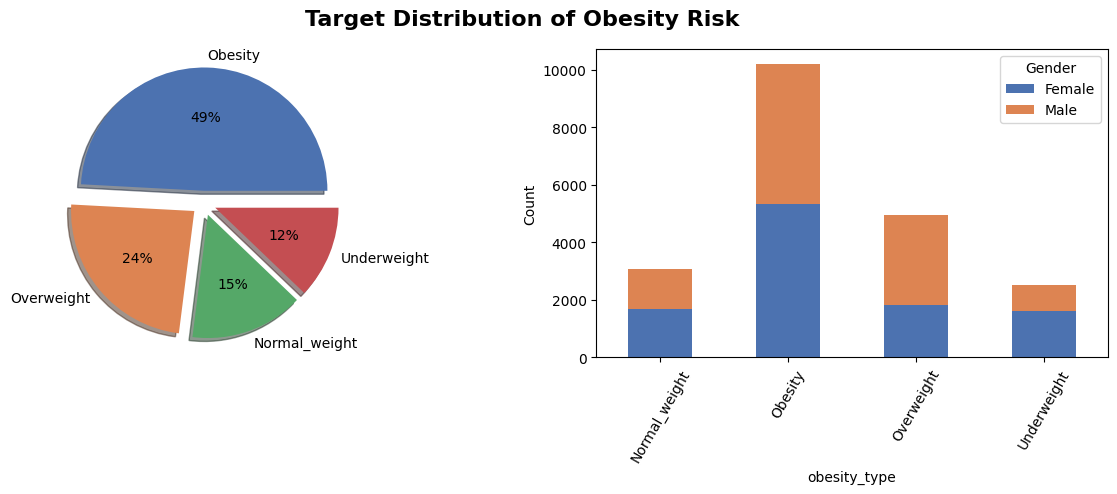

In [9]:
fig, axs = plt.subplots(1,2,figsize = (12,5))
plt.suptitle("Target Distribution of Obesity Risk", fontsize=16, fontweight='bold')

axs[0].pie(
        preprocessed_df[TARGET].value_counts(),
        shadow = True,
        explode=[.1 for i in range(preprocessed_df[TARGET].nunique())],
        labels = preprocessed_df[TARGET].value_counts().index,
        autopct='%1.f%%',
        colors=palette
    )

obesity_risk_gender = preprocessed_df.groupby([TARGET, 'Gender']).size().unstack()
obesity_risk_gender.plot(kind='bar', stacked=True, color=palette, ax=axs[1])

axs[1].set_xlabel(TARGET)
axs[1].set_ylabel('Count')
axs[1].legend(title='Gender')
axs[1].tick_params(axis='x', rotation=60)

plt.tight_layout()
plt.show()

## 3.2 Target Variable Distribution, by Numerical Features

Numerical features in the dataset include Age, Height, Weight, BMI

* Age Distribution: The histogram reveals a right-skewed age distribution, indicating a higher concentration of individuals in their late teens to early 30s. This pattern may reflect data collection biases, particularly in online surveys where younger, tech-savvy individuals are more likely to participate.

* BMI and Obesity Risk: The violin plot confirms a clear differentiation in BMI across obesity risk classifications. Underweight individuals exhibit significantly lower BMI values, while the 'Obesity_Severe' category shows a wide range of high BMI values.

* Gender and Weight Variability: While both height and weight distributions vary across genders, BMI remains relatively stable across most categories. However, females classified as 'Obesity_Severe' tend to have higher BMI values, indicating a stronger variance in obesity prevalence between genders.

* Obesity and Age Relationship: The analysis suggests a positive correlation between increasing age and higher obesity risk. Middle-aged and older individuals exhibit higher BMI values, likely due to metabolic changes, lean mass reduction, and lifestyle shifts.

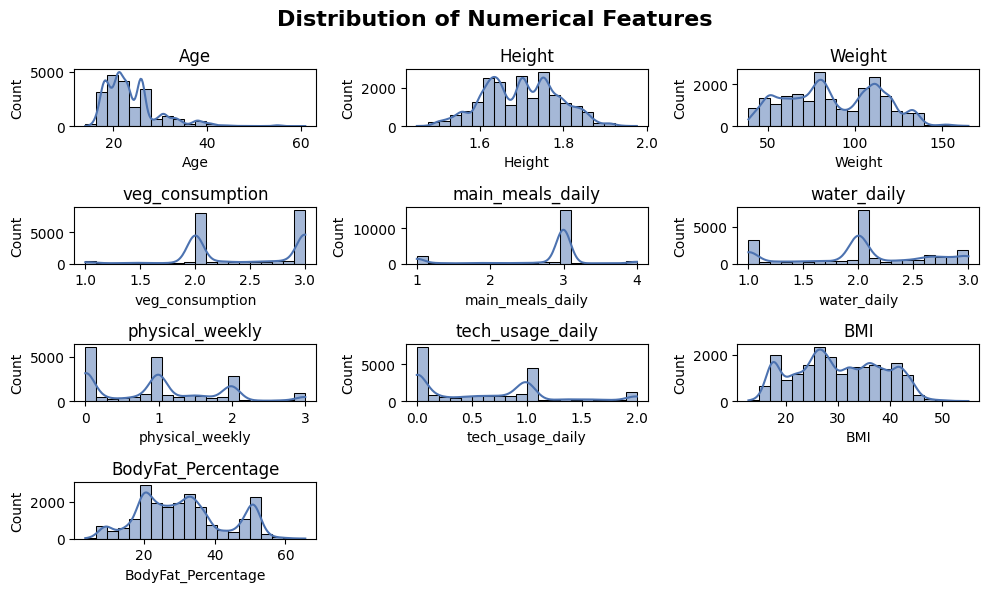

In [10]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(10, 6))

axs = axs.flatten()

raw_num_cols = data_df.select_dtypes(include=['float64', 'int64']).columns
raw_num_cols = raw_num_cols.drop("id")

for i, col in enumerate(raw_num_cols):
    sns.histplot(data_df[col], ax=axs[i], bins=20, kde=True, stat='count')  
    axs[i].set_title(col)
    axs[i].grid(False)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle("Distribution of Numerical Features", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

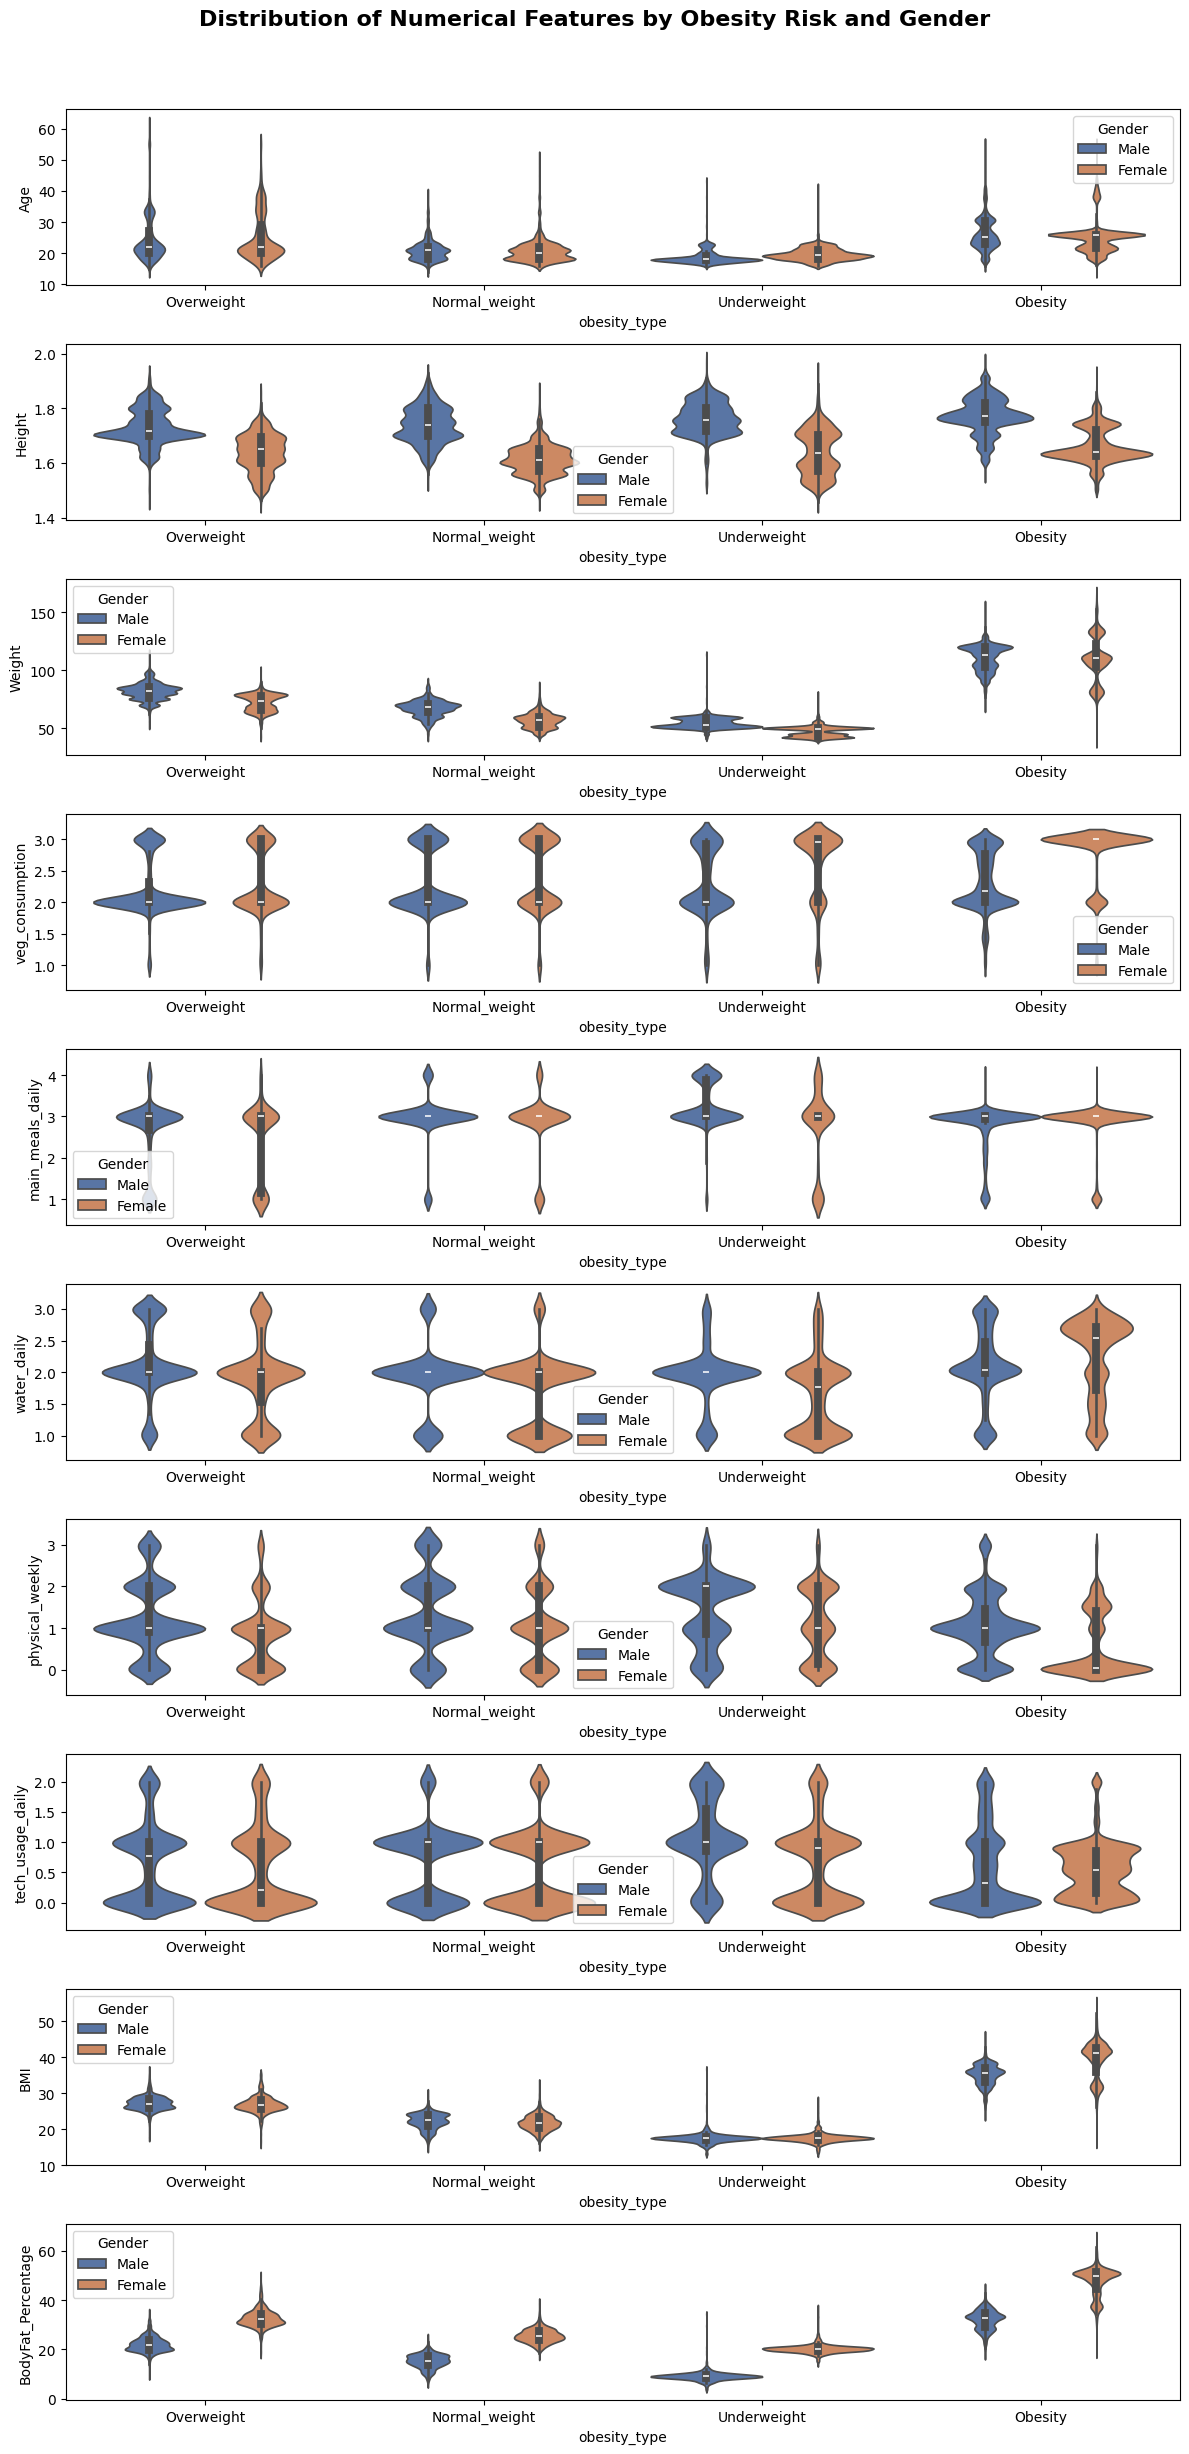

In [11]:
fig,axs = plt.subplots(len(raw_num_cols),1,figsize=(12,len(raw_num_cols)*2.5),sharex=False)

for i, col in enumerate(raw_num_cols):
    sns.violinplot(x=TARGET, y=col,hue="Gender", data=preprocessed_df,ax = axs[i], split=False)

fig.suptitle("Distribution of Numerical Features by Obesity Risk and Gender", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

## 3.3 Target Variable Distribution, by Categorical Features

- Binary columns: 'Gender', 'family_history_with_overweight', 'highcal_intake', 'SMOKE', 'track_cal_intake'
- Categorical columns: 'transport_mode'
- Ordinal columns: 'veg_intake', 'meals_daily', 'snacking', 'water_intake_daily', 'physical_weekly', 'tech_usage_daily', 'alcohol_intake'

Observing the counts of each binary, categorical and ordinal feature, some key observations:
- There are many features where the responses obtained are not even. For example, most responses are from non-smokers, people who frequently consume high calorie food, do not track calorie intake, commute by car or public transport. However, these are still relevant lifestyle factors to consider in the model. Additional caution will be taken into account when interpreting the results subsequently.
- Almost all individuals in the 'Obesity' and 'Obesity_Severe' categories have a family history of overweight, high calorie intake and do not track their calorie intake.
- There are hardly any individuals in the 'Obesity' and 'Obesity_Severe' categories that commute by walking, and there are sizably more individuals in these categories that have 0 days of physical activity each week.
- Interestingly, there are hardly any individuals from the 'Obesity' and 'Obesity_Severe' categories that have more than 3 meals a day. A bulk of individuals in the 'Obesity_Severe' will always consume vegetables too. This may be due to efforts to reduce weight or eat less. While there are some individuals from the 'Obesity' and 'Overweight category' that will have only 1-2 meals a day, most individuals from the 'Obesity_Severe' category will consume 3 meals a day.

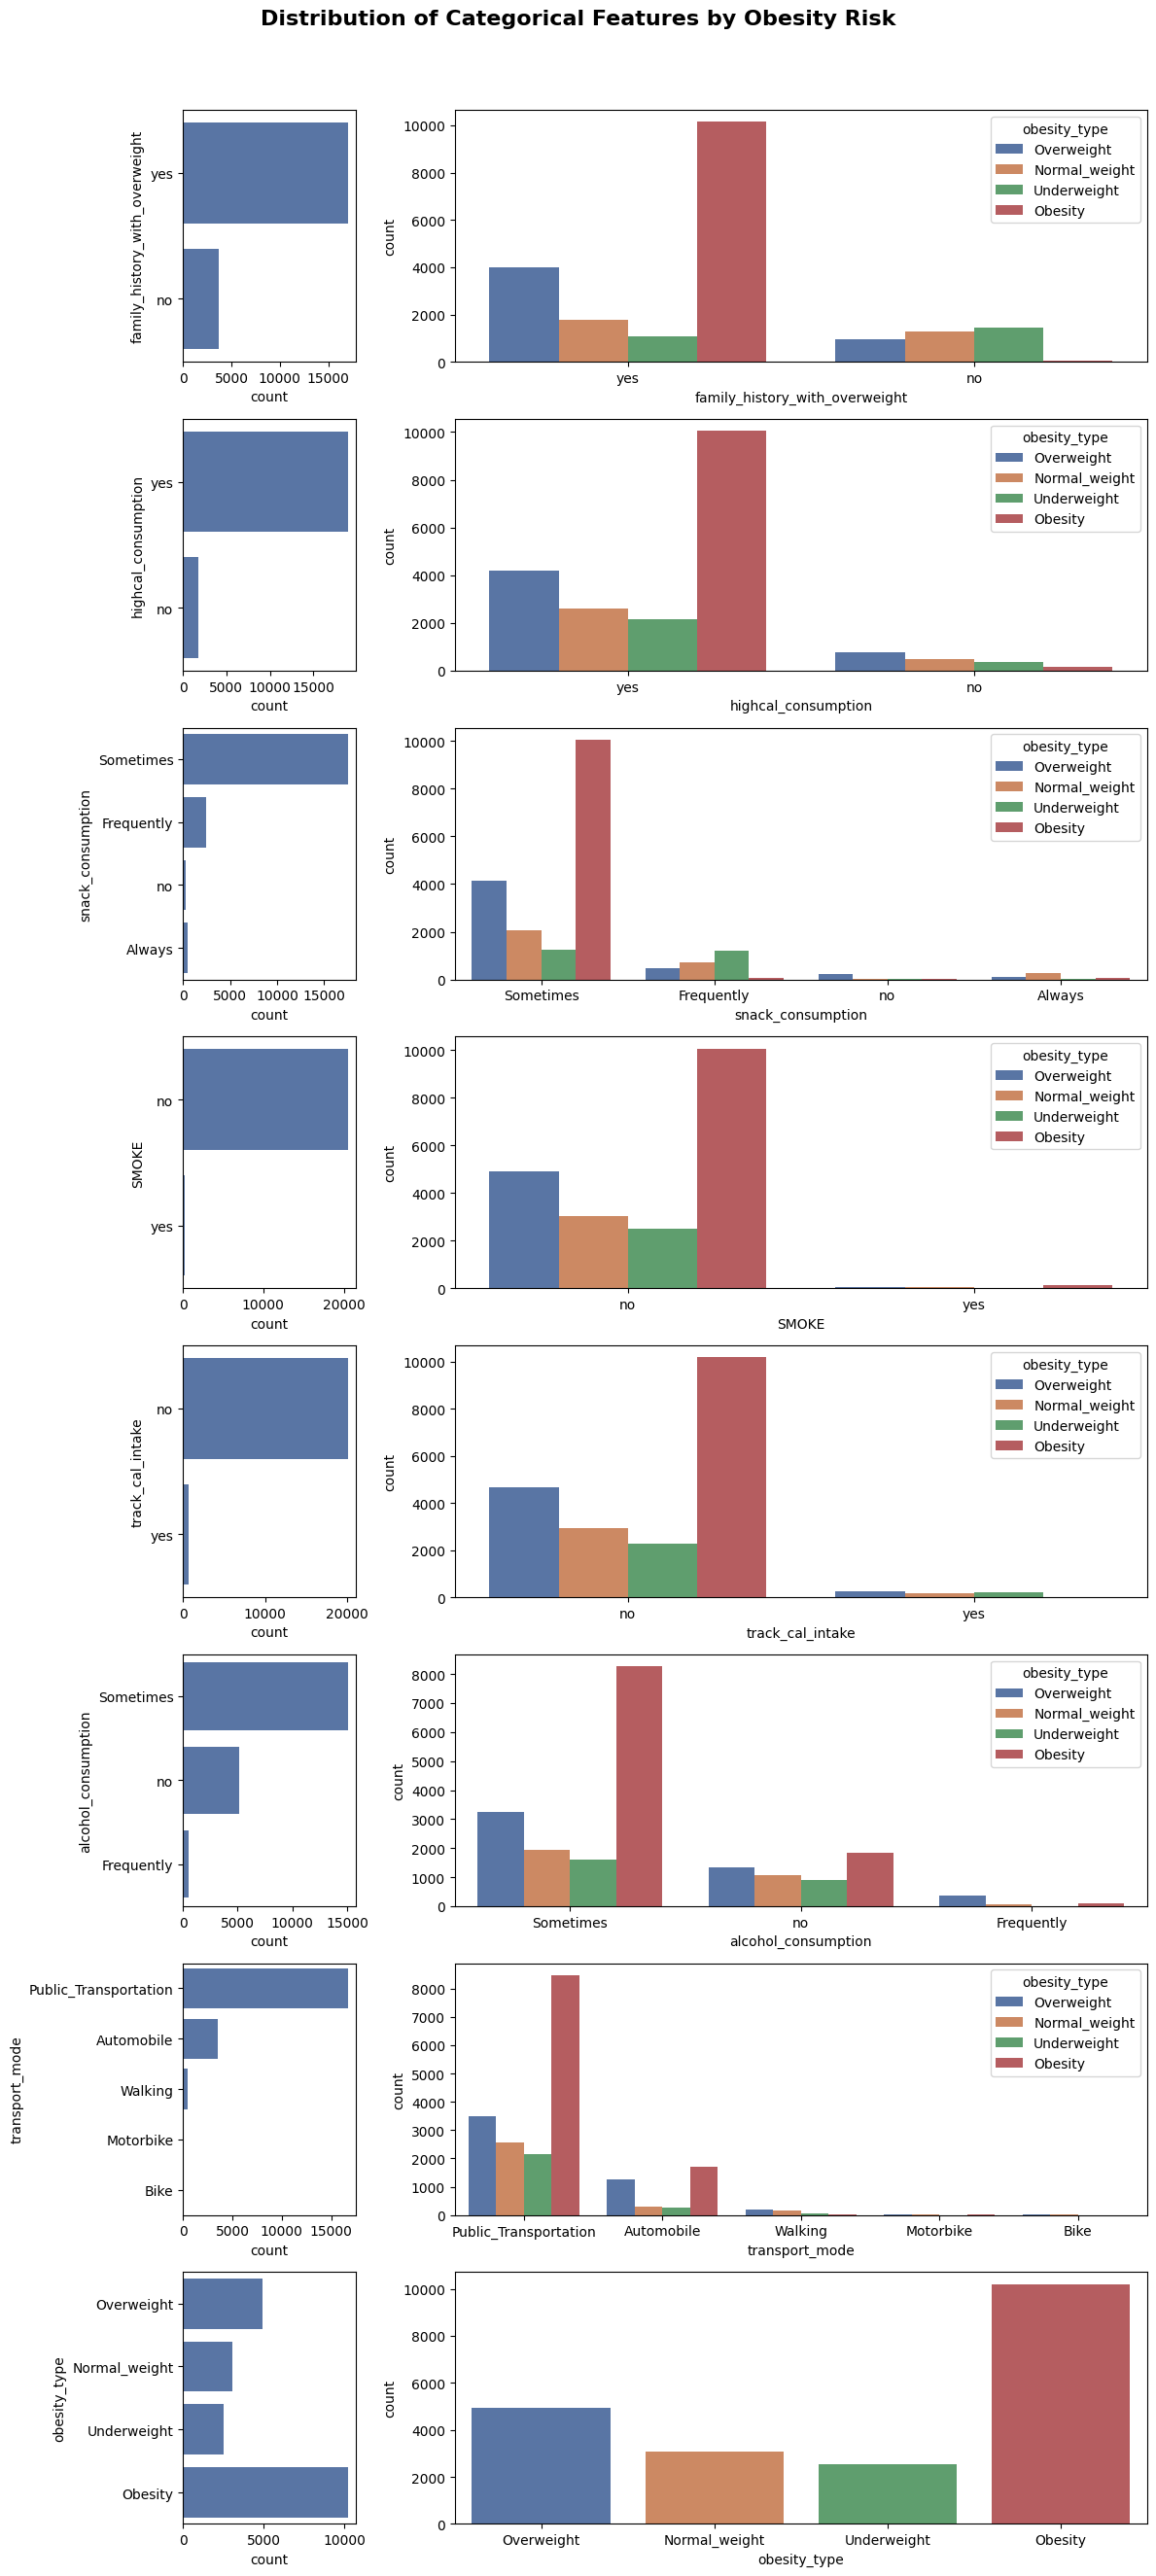

In [12]:
raw_cat_cols = preprocessed_df.select_dtypes(include=['object']).columns

fig, axs = plt.subplots(int(len(raw_cat_cols) - 1), 2, figsize=(12, len(raw_cat_cols) * 3), width_ratios=[1, 4])

fig.suptitle("Distribution of Categorical Features by Obesity Risk", fontsize=16, fontweight='bold')

for i, col in enumerate(raw_cat_cols[1:]):
    sns.countplot(y=col, data=preprocessed_df, palette=palette, ax=axs[i, 0])
    sns.countplot(x=col, data=preprocessed_df, hue=TARGET, palette=palette, ax=axs[i, 1])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 3.4 Pearson Correlation Matrix of numerical features

Key observations:
- There appears to be a weak positive correlation between Age & BMI (0.32) and Age & the feature engineered variiable Body Fat Percentage (0.34).
- There is a high correlation between Weigh, BMI, and Body Fat Percentage, which is expected.

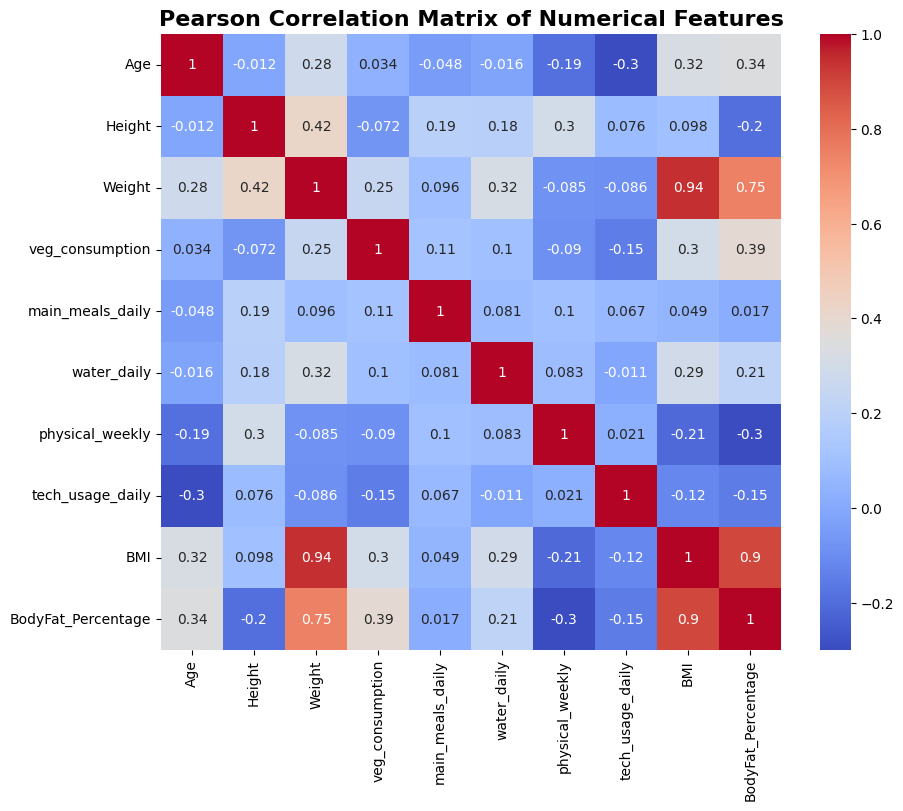

In [13]:
corr_matrix = preprocessed_df[raw_num_cols].corr("pearson")
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap ="coolwarm")
plt.title("Pearson Correlation Matrix of Numerical Features", fontsize=16, fontweight='bold')
plt.show()